# Probabilistic Programming

Probabilistic programming is a way of building probabilistic models to describe stochastic processes observed in the real world. One has the power to incorporate domain knowledge to build a bespoke modelling solution to a specific problem. Once the model has been set up, inference is then performed to deduce the most likely explanation of the data. But why should we care about such models? B. Cronin writes:

'Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories - thus the unreasonable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options.

But probabilistic programs can be written in an explicitly "generative" fashion - i.e., a program directly encodes a space of hypotheses, where each one comprises a candidate explanation of how the world produced the observed data. The specific solutions that are chosen from this space then constitute specific causal and narrative explanations for the data.'   <br>
<a href='https://plus.google.com/+BeauCronin/posts/KpeRdJKR6Z1'>Full article here</a>

## Experiment
We set up a simple experiment in the office to explore the use of probabilistic programming. The data has been collected by recording the successes and failures of Andrew throwing a piece of paper into the bin. The results after many days of performing this task are recorded below.

In [1]:
import numpy as np
data = np.array([ True, False, False, False, False, False, False, False, False,
        True, False,  True,  True, False, False, False, False,  True,
        True,  True, False, False, False,  True, False, False, False,
       False, False,  True, False, False,  True,  True,  True,  True,
       False, False, False,  True, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False,  True,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True, False,  True, False, False,  True, False,  True,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False,  True,  True,
       False,  True,  True, False, False, False, False, False,  True,
        True, False, False, False, False,  True, False,  True, False,
       False, False,  True,  True,  True, False, False,  True,  True,
       False,  True, False, False,  True,  True, False,  True,  True,
       False, False, False, False,  True,  True])
n_trials = len(data)

Each data point is a random variable $X_i$ modelled as a Bernoulli trial with a given probability $p$. <br>
$X_i$ ~ $Ber(p)$ <br>
Assumptions that must be followed:
  - Two possible outcomes (success or failure)
  - The probability of success remains constant from trial to trial
  - The trails are independent

The second assumption may be a bit dubious as one might expect skill level to increase.

## Bayesian Inference
We want to calculate the distribution of $p$ given the data $x$, that is $P(p|x)$ known as the posterior. This can be achieved through Baye's rule as follows. Assume a prior distribution on the distribution of $p$,  call it $P(p)$. Assumming that the data follows a sequence of Bernoulli trials, we can calculate the likelihood function given by $P(x|p)$. Finally we need to calculate the marginal likelihood, sometimes called the evidence which is the probability of the data regardless of the value of $p$ given by $P(x)$. The posterior distribution is then given by: <br> <br>
$P(p|x) = \dfrac{P(p) P(x|p)}{P(x)}$ <br>

This can be calculated analytically for simple problems such as this (cf conjugate priors), but when more complex models are created (as will be done later) or systems with large numbers of parameters, the calculations quickly become intractable. Enter Markov Chain Monte Carlo (MCMC). This algorithm allows us to sample from the posterior distribution to get a sense of what it looks like. There are many frameworks that can achieve this but PyMC3 feels like the simplest.

## Probabilistic Programming with PyMC3
One begins by creating a model by using a context manager and PyMCs various built in distributions. We will use an uninformative prior, that is assume every probability $p$ equally likely by using a continuous uniform distribution.

In [2]:
import pymc3 as pm

with pm.Model() as model:
    # Prior distribution for the probability p, P(p)
    p = pm.distributions.Uniform('p', lower=0, upper=1)
    
    # The observed data follows a bernoulli distribution with a probability p, passed from above
    # Since this is observed we pass it in using the keyword argument observed
    x = pm.distributions.Bernoulli('x', p=p, observed=data)

Now enters the magic sauce that makes it all work. Here a specific MCMC method is used, namely Metropolis-Hastings. This samples from the posterior and collects the samples into trace.

In [3]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(20000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████| 100000/100000 [00:29<00:00, 3415.41draws/s]
The number of effective samples is smaller than 25% for some parameters.


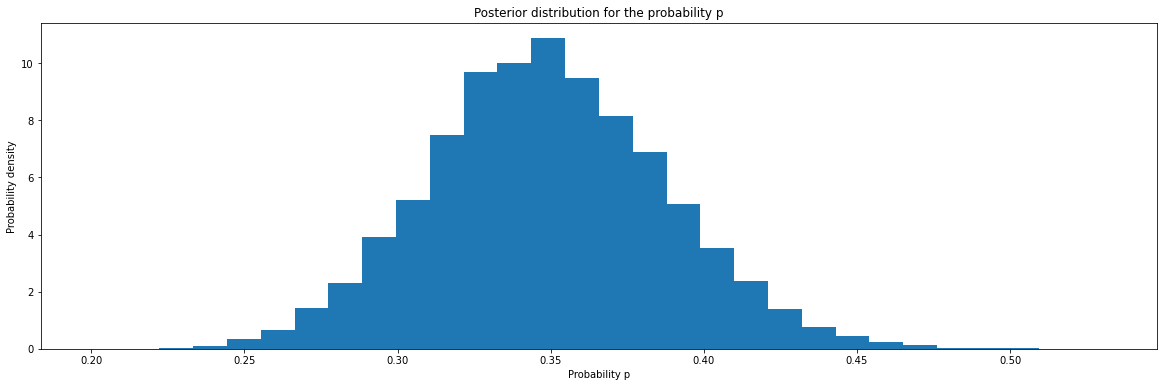

In [4]:
p_samples = trace['p']

import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(20, 6))
_ = plt.hist(p_samples, bins=30, density=True)
_ = plt.title('Posterior distribution for the probability p')
_ = plt.xlabel('Probability p')
_ = plt.ylabel('Probability density')

## Asking questions
One typically wants to know how precise a given parameter is. From the posterior distribution we can construct a credibility interval which states the probability of a parameter lying within a certain interval. This is different from the frequentist confidence interval where model parameters are fixed and one asks - 'were this procedure to be repeated on numerous samples, the fraction of calculated confidence intervals (which would differ for each sample) that encompass the true population parameter would tend toward a particular percentage'. The credibility interval is certainly more intuitive!

It is also simple to calculate the interval in the following way, along with point estimates of the parameter.

In [5]:
p_mean = np.mean(p_samples)
p_cred_int = np.percentile(p_samples, [2.5, 97.5])

print(f'The mean value of p is {p_mean}')
print(f'The 95% credibility interval is {p_cred_int[0]} to {p_cred_int[1]}')

The mean value of p is 0.34885526921093735
The 95% credibility interval is 0.27543852454019524 to 0.4262862474452019


## More complicated hierarchical model
Suppose now we have reason to believe that Andrew actually got better at successfully throwing the piece of paper in the bin. We could model this as two different probabilities $p_1$ and $p_2$ and suppose that at some time $\tau$ the probability before is $p_1$ and after is $p_2$.

But what is the value of $\tau$? We treat it as another random variable in our model and let the inference system calculate this for us.

We can again model this and perform inference using PyMC. We will again use the uninformative priors of a continuous uniform distribution for the probabilities $p_1$ and $p_2$ and will use a discrete uniform distribtuion for the value of $\tau$.

In [6]:
with pm.Model() as h_model:
    
    # The uninformative priors for the two probabilities
    p_1 = pm.distributions.Uniform('p_1', lower=0, upper=1)
    p_2 = pm.distributions.Uniform('p_2', lower=0, upper=1)
    
    # The uninformative prior for the switching point tau
    tau = pm.distributions.DiscreteUniform('tau', lower=0, upper=(n_trials - 1))
    
    # Setting up the value of p by switching when idx is greater than tau
    idx = range(n_trials)
    p = pm.math.switch(tau > idx, p_1, p_2)
    
    # Putting in the oberseved data
    x = pm.distributions.Bernoulli('x', p=p, observed=data)

In [7]:
# Running the algorithm again
with h_model:
    step_h = pm.Metropolis()
    trace_h = pm.sample(20000, tune=5000,step=step_h)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [p_2]
>Metropolis: [p_1]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████| 100000/100000 [00:42<00:00, 2357.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


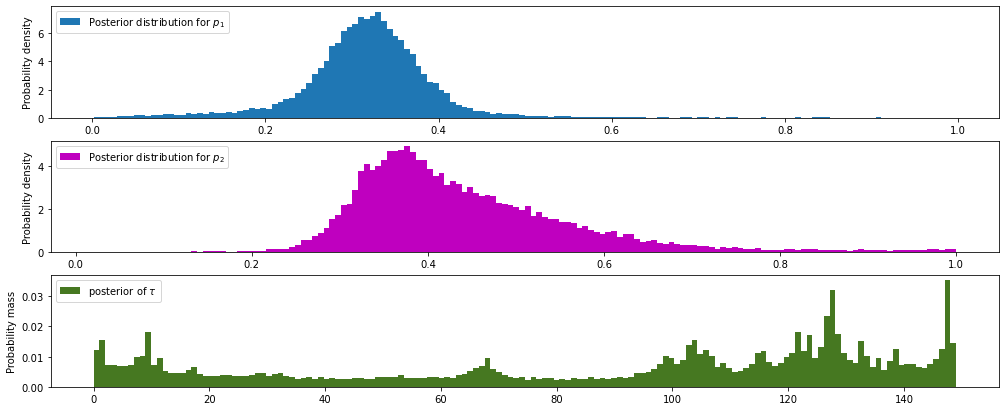

In [8]:
p_1_samples = trace_h['p_1']
p_2_samples = trace_h['p_2']
tau_samples = trace_h['tau']

plt.figure(figsize=(17, 7))

ax = plt.subplot(311)
_ = plt.hist(p_1_samples, bins=n_trials, density=True, label=r'Posterior distribution for $p_1$')
_ = plt.ylabel('Probability density')
_ = plt.legend(loc='upper left')

ax = plt.subplot(312)
_ = plt.hist(p_2_samples, bins=n_trials, density=True, label=r'Posterior distribution for $p_2$', color='m')
_ = plt.ylabel('Probability density')
_ = plt.legend(loc='upper left')

ax = plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
_ = plt.hist(tau_samples, bins=n_trials, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)

_ = plt.ylabel('Probability mass')

_ = plt.legend(loc='upper left')

Plotting the posterior distributions above we see that there appears to be a slight increase in the mean going from $p_1$ to $p_2$. The value of $\tau$ is not so clear cut but seems more likely to happen after 100 trials.

Finall we can combine all these sampled posterior distributions to visualize the expected probability against the number of trials.

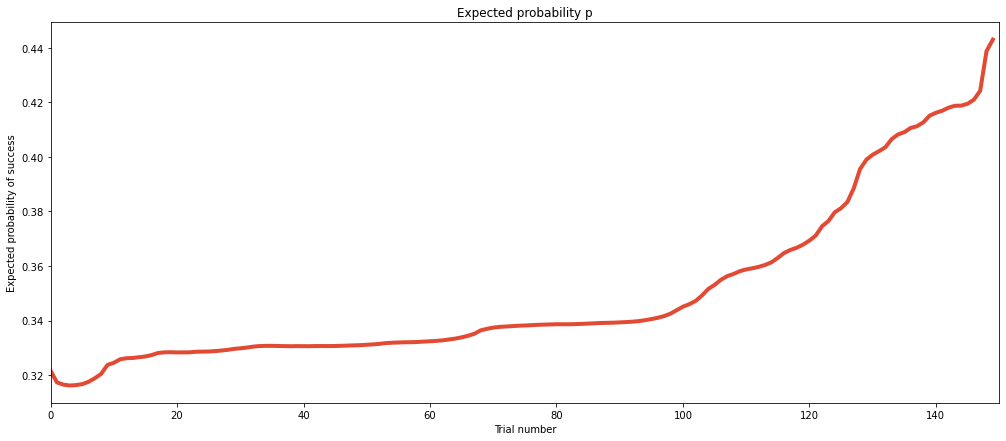

In [9]:
plt.figure(figsize=(17, 7))
# tau_samples, p_1_samples, p_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_p_each_trial = np.zeros(n_trials)
for day in range(0, n_trials):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the p_1 "regime") or
    #  "after" (in the p_2 "regime") the switchpoint.
    # by taking the posterior sample of p1/2 accordingly, we can average
    # over all samples to get an expected value for p on that day.
    
    
    expected_p_each_trial[day] = (p_1_samples[ix].sum()
                                   + p_2_samples[~ix].sum()) / N


plt.plot(range(n_trials), expected_p_each_trial, lw=4, color="#E24A33")
plt.xlim(0, n_trials)
plt.xlabel("Trial number")
plt.ylabel("Expected probability of success")
_ = plt.title("Expected probability p")


It looks clear that the probability of success has increase over the 150 trials!

### Extra resources

  - Most of the code in this notebook was inspired by the book/repo 'Probabilistic Programming for Hackers' by Cameron Davidson-Pilon and can be found <a href='https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers'>here</a>
  - An interesting talk from Zach Anglin that gives a good intuition on to how MCMC works can be found <a href='https://www.youtube.com/watch?v=5f-9xCuyZh4&t=2327s'>here</a>
  - A <a href='https://twiecki.io/'>blog</a> from Thomas Wiecki (VP of Data Science at Quantopian) on various Bayesian/probabilistic methods
  - A set of <a href='https://www.stat.auckland.ac.nz/~brewer/stats331.pdf'>notes</a> on Bayesian Statistics